# Library Import

In [96]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import matplotlib as mpl

import warnings

In [97]:
warnings.filterwarnings("ignore")
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드

In [98]:
jj = pd.read_csv('./전처리최종파일/jj_shift.csv').drop('Unnamed: 0', axis=1)
jj.head()

,날짜,지역,관광객,FESTIVAL,기온(°C),습도(%),강수량(mm),scaled,관광객_차분(1),코로나인원,holliday,누적확진(명),신규확진(명),shift(1),shift(2),shift(3),shift(4),shift(5)
0,2019-03-01,전주시,243514,0,9.957143,43.714286,0.0,0.804789,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-03-02,전주시,250850,0,12.485714,38.428571,0.0,0.844920,7336.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03-03,전주시,197335,0,13.100000,44.142857,0.0,0.552171,-53515.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-03-04,전주시,171854,0,11.585714,57.142857,0.0,0.412780,-25481.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-03-05,전주시,176674,0,12.242857,46.285714,0.0,0.439147,4820.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [100]:
# params
splits = -5
lr = 0.05
n_estimator = 100
gamma = 0.05

## Data Split

In [101]:
jj_data = jj.drop(['날짜', '지역', 'scaled', '관광객_차분(1)', '코로나인원', '신규확진(명)'], axis=1)
col_Y = ['관광객']
jj_data = jj_data[:-2]

jj_train = jj_data[:splits]
jj_trainX, jj_trainy = jj_train[jj_train.columns.difference(col_Y)], jj_train[col_Y]
jj_test = jj_data[splits:]
jj_testX, jj_testy = jj_test[jj_test.columns.difference(col_Y)], jj_test[col_Y]

In [102]:
import xgboost as xgb

## Model making

In [103]:
model = xgb.XGBRegressor(booster='gbtree', gamma=0.01, learning_rate=0.07, max_depth=5)
model_tree = xgb.XGBRegressor(booster='gbtree', eval_metric='mae', learning_rate=lr, n_estimators=n_estimator, gamma=gamma)

## Model train and test

In [104]:
model.fit(jj_trainX, jj_trainy)
model_tree.fit(jj_trainX, jj_trainy)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae',
             gamma=0.05, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

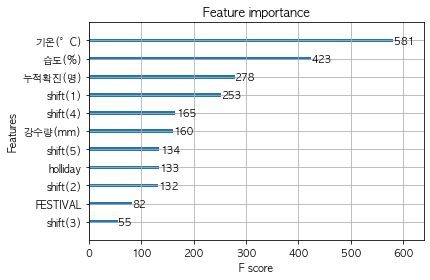

In [105]:
xgb.plot_importance(model_tree)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

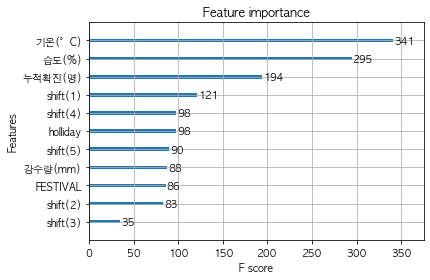

In [111]:
xgb.plot_importance(model)

In [106]:
tree_pred = model_tree.predict(jj_testX)
pred = model.predict(jj_testX)

In [107]:
mae_tree = mean_absolute_error(tree_pred, jj_testy)
mae = mean_absolute_error(pred, jj_testy)

In [108]:
print('tree model precition and real case\n')
print(np.round(tree_pred))
print(np.array(jj_testy).reshape(-1))

print('-'*50)

print('linear model precition and real case\n')
print(np.round(linear_pred))
print(np.array(jj_testy).astype(float).reshape(-1))

print('-'*50)
print(f'tree boosting MAE : {mae_tree}')
print(f'GridSearch boosting MAE : {mae}')

tree model precition and real case

[152923. 157715. 157467. 176158. 234909.]
[156915 159484 158652 176615 228399]
--------------------------------------------------
linear model precition and real case

[187573.  74313. 216153. 220153. 181623.]
[156915. 159484. 158652. 176615. 228399.]
--------------------------------------------------
tree boosting MAE : 2782.73125
GridSearch boosting MAE : 4391.853125


In [109]:
pred_df = pd.DataFrame(columns=['number', 'tree_pred','linear_pred', 'real'])
pred_df['number'] = [1,2,3,4,5]
pred_df['tree_pred'] = tree_pred
pred_df['GridSearch_pred'] = pred
pred_df['real'] = np.array(jj_testy).astype(float).reshape(-1)

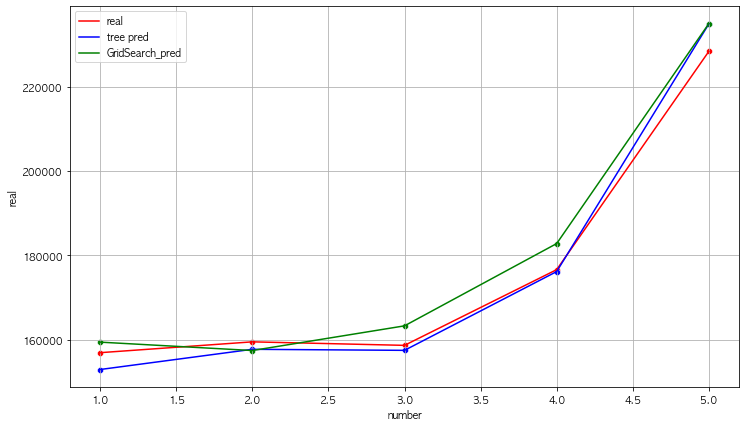

In [110]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=pred_df,x='number', y='real', color='r')
sns.scatterplot(data=pred_df,x='number', y='real', color='r')
sns.lineplot(data=pred_df,x='number', y='tree_pred', color='b')
sns.scatterplot(data=pred_df,x='number', y='tree_pred', color='b')
sns.lineplot(data=pred_df,x='number', y='GridSearch_pred', color='g')
sns.scatterplot(data=pred_df,x='number', y='GridSearch_pred', color='g')

plt.legend(labels=['real', 'tree pred', 'GridSearch_pred'])
plt.grid()
plt.show()